# ***Project 5: Support Vector Classifaction***
## **Problem 2**: Vowel Recognition Problem
## **Author**: Ian R. Stewart
## **Due**: December 8, 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
import random; import sys
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing and Exploration

In [2]:
features = ['Train or Test','Speaker Number','Sex','Feature 0','Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6','Feature 7','Feature 8','Feature 9','Class']
df = pd.read_csv('./vowel-context.data',sep='\s+',names=features)
df_classes = df.iloc[:,-1]
# Using StandardScaler to standardize the data.
scaler = StandardScaler()
scaler.fit(df.iloc[:,0:-1])
df_normed = scaler.transform(df.iloc[:,0:-1])

In [3]:
df.head()

,Train or Test,Speaker Number,Sex,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Class
0,0,0,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,0
1,0,0,0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,0,0,0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2
3,0,0,0,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,3
4,0,0,0,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,4


In [4]:
print '- SHAPE OF ARRAY:'
print '\t'+ str(df.shape)
print '- UNIQUE CLASSIFICATION VALUES:'
print '\t'+ str(df['Class'].unique())

- SHAPE OF ARRAY:
	(990, 14)
- UNIQUE CLASSIFICATION VALUES:
	[ 0  1  2  3  4  5  6  7  8  9 10]


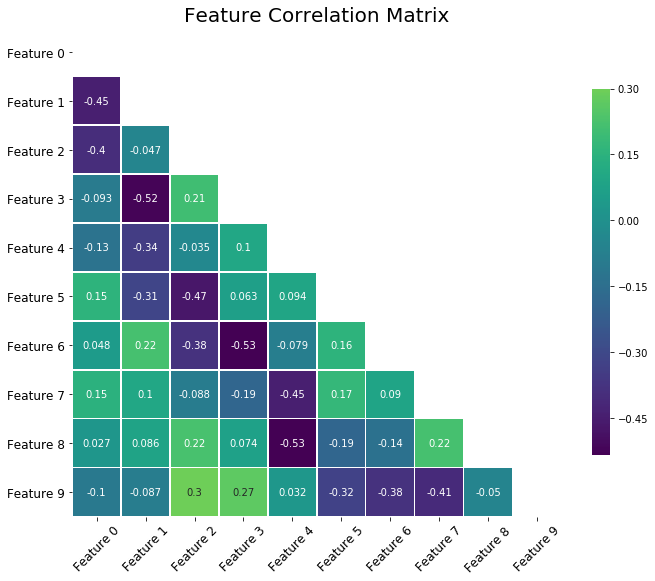

In [5]:
def correlation_matrix(df,savefig=False):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm
    import seaborn as sns
    labels=['Feature 0','Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6','Feature 7','Feature 8','Feature 9',]
    corr = df[labels].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax1 = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, mask=mask, cmap='viridis',annot=True, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .75})
    ax1.grid(True)
    plt.title('Feature Correlation Matrix',fontsize=20)
    labels=['Feature 0','Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6','Feature 7','Feature 8','Feature 9']
    ax1.set_xticklabels(labels,fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    ax1.set_yticklabels(labels,fontsize=12)
    ax1.grid(False)
    if savefig:
        plt.savefig('./Figures/Vowel_heatmap.png',dpi=400)

correlation_matrix(df,False)

In [49]:
df.dtypes

Train or Test       int64
Speaker Number      int64
Sex                 int64
Feature 0         float64
Feature 1         float64
Feature 2         float64
Feature 3         float64
Feature 4         float64
Feature 5         float64
Feature 6         float64
Feature 7         float64
Feature 8         float64
Feature 9         float64
Class               int64
dtype: object

Train or Test	:   2
Speaker Number	:   15
Sex		:   2
Feature 0	:   853
Feature 1	:   877
Feature 2	:   815
Feature 3	:   836
Feature 4	:   803
Feature 5	:   798
Feature 6	:   748
Feature 7	:   794
Feature 8	:   788
Feature 9	:   775
Class		:   11


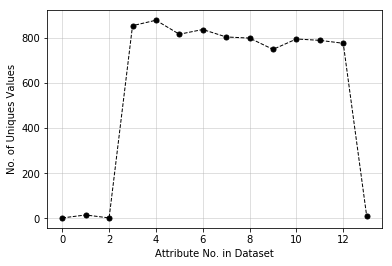

In [13]:
uniques = []
for i in range(df.shape[1]):
    uniques.append(len(df[features[i]].unique()))
    if (features[i]=='Sex'):
        print '%s\t\t:   %i'%(features[i],uniques[i])
    elif (features[i]=='Class'):
        print '%s\t\t:   %i'%(features[i],uniques[i])
    else:
        print '%s\t:   %i'%(features[i],uniques[i])
plt.plot(uniques,'ko--',linewidth=1,markersize=5)
plt.grid(alpha=0.5);plt.ylabel('No. of Uniques Values');plt.xlabel('Attribute No. in Dataset')
if False:
    plt.savefig('./Figures/Unique_values_data_vowel.png',dpi=400)

In [14]:
df.isnull().values.any()

False

## SVM Analysis


In [15]:
import random
def test_split(data_x,data_y,n):
    '''
    Description: Splits <data> variable into four random 
        parts based on <n> percentage of data for training 
        set.
    
    :param data_x {array} : x data to split,train,predict
    :param data_y {array} : y data to split,train,predict
    :param n      {float} : percentage of data to split
    
    :returns {6}: (x_train,x_test,y_train,y_test) ;     
        x_train = training set for <x> parameter
        x_test  = test set for <x> parameter
        y_train = training set for <y> paramter
        y_test  = test set for <y> parameter
        i_train = indexes of training set split
        i_test  = indexes of test set split
    
    e.g. x_tr,x,y_tr,y,i_tr,i_test=test_split(data_features,data_classes,40)
    '''
    data_x = np.asarray(data_x)
    length_test = int(round(len(data_x)*(n/100.)))
    # Create random integers between two numbers with no repeats
    train_list = random.sample(range(0,len(data_x)), length_test)
    train_list.sort()
    test_list = np.arange(0,len(data_x))
    test_list = np.delete(test_list,train_list)
    data_y = np.array(data_y)
    x_train,y_train = np.array(data_x[train_list]),np.array(data_y[train_list])
    x_test,y_test   = np.array(data_x[test_list]),np.array(data_y[test_list])
    
    return (x_train,x_test,y_train,y_test,train_list,list(test_list))

In [16]:
(x_train,x_test,y_train,y_test,train_list,test_list) = test_split(df_normed[:,3:],df_classes,40)

In [21]:
model = svm.SVC()
model.fit(x_train,y_train)
print 'Training accuracy: %.4f'%model.score(x_train,y_train)
predicted = model.predict(x_test)
print 'Test accuracy:\t   %.4f'%model.score(x_test,y_test)

Training accuracy: 0.9520
Test accuracy:	   0.8451


In [22]:
print '\n'
print classification_report(y_test,predicted)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.89      1.00      0.94        48
           2       1.00      0.82      0.90        57
           3       0.84      0.80      0.82        54
           4       0.84      0.49      0.62        63
           5       0.55      0.87      0.68        47
           6       0.71      0.89      0.79        53
           7       0.93      0.89      0.91        56
           8       0.85      0.96      0.90        48
           9       1.00      0.86      0.92        56
          10       0.86      0.81      0.83        59

   micro avg       0.85      0.85      0.85       594
   macro avg       0.86      0.85      0.85       594
weighted avg       0.87      0.85      0.84       594



In [23]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf','sigmoid','poly'), 'C':[0.1,1,5,10],'gamma':[0.001,0.01,0.1,1]}
svc = svm.SVC(gamma='scale')
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf', 'sigmoid', 'poly'), 'C': [0.1, 1, 5, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
clf.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Using previous values from grid search to perform a fine grid search.

In [25]:
accuracy = []; c = []; kernel = []
C_list = list(np.linspace(7.5,15,50)) # creating list of 50 values between 7.5 and 15
Gamma_list = list(np.linspace(0.01,0.1,20)) # creating list of 20 values between 0.01 and 0.1
# Creating training-test split
parameters = {'kernel':('linear', 'rbf'), 'C':C_list,'gamma':Gamma_list}
svc = svm.SVC(gamma='scale')
svc.fit(x_train,y_train)
accuracy.append(svc.score(x_test,y_test))
svc = svm.SVC(gamma='scale')
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(x_train,y_train)
# Appending hyperparameter values from GridSearchCV()
c.append(clf.best_params_['C'])
kernel.append(clf.best_params_['kernel'])

In [26]:
clf.best_params_

{'C': 13.16326530612245, 'gamma': 0.08105263157894736, 'kernel': 'rbf'}

In [30]:
svc = svm.SVC(C= 13.16326530612245, gamma= 0.08105263157894736, kernel= 'rbf')
svc.fit(x_train,y_train)
print svc.score(x_test,y_test)

0.9528619528619529
